In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
torch.set_printoptions(threshold=torch.inf)
import numpy as np
import random

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

sys.path.append(os.path.dirname(os.getcwd())) #Add project dir to path
from utils.loadutils import standardize_vidimu
# from utils.loadutils2 import standardize_vidimu
# from utils.loadutils3 import standardize_vidimu
# from utils.loadutils4 import standardize_vidimu

def set_random_seed(seed=42):
    """Set random seed for reproducibility."""
    random.seed(seed)            # Python random module
    np.random.seed(seed)         # NumPy
    torch.manual_seed(seed)      # PyTorch
    torch.cuda.manual_seed_all(seed)  # For multi-GPU systems

    # Ensure deterministic behavior in some backends (optional)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this at the beginning of your training script
set_random_seed(42)


In [6]:
# trainpath = '/Volumes/Data_Drive/datasets/VIDIMU/dataset/videoandimusyncrop'
# testpath = '/Volumes/Data_Drive/datasets/VIDIMU/dataset/videonly'
gridsearch_path = "/Volumes/Data_Drive/vidimu_gridsearch_out/gridsearch_11_4"
# gridsearch_path = "/Volumes/Data_Drive/vidimu_gridsearch_out/gridsearch_11_26"
activities = ["A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10", "A11", "A12", "A13"]
# num_classes = len(activities)  # Number of activities

In [7]:
secs=[0.5, 0.75, 1.5, 4.0]
depth=[1, 2, 7, 14]
modelnames=["Pos_ResNet", "Ang_ResNet", "AngPos_ResNet"]

In [8]:
import re
import pandas as pd

def parse_log_file(log_file_path, m, d, s):
    # Define regex patterns
    fold_start_pattern = r"Starting fold (\d+)/\d+"
    fold_end_pattern = r"Completed fold (\d+)/\d+"
    best_model_pattern = r"New best model for fold (\d+)"
    metrics_pattern = r"Epoch \[\d+/\d+\], Loss: ([\d.]+), Train Accuracy: ([\d.]+), Test Accuracy: ([\d.]+), Precision: ([\d.]+), Recall: ([\d.]+), F1-Score: ([\d.]+)"

    # Initialize variables
    fold_data = []
    current_fold = None
    lines_buffer = []
    
    # Process the log file line by line
    with open(log_file_path, "r") as file:
        for line in file:
            # Check for fold start
            fold_start_match = re.search(fold_start_pattern, line)
            if fold_start_match:
                current_fold = int(fold_start_match.group(1))
                lines_buffer = []  # Reset buffer for new fold
                continue
            
            # Check for fold end
            fold_end_match = re.search(fold_end_pattern, line)
            if fold_end_match and int(fold_end_match.group(1)) == current_fold:
                # Process buffer for the completed fold
                last_best_model_idx = None
                for i, buffered_line in enumerate(lines_buffer):
                    if re.search(best_model_pattern, buffered_line):
                        last_best_model_idx = i
                
                # Extract metrics if last_best_model_idx is found
                if last_best_model_idx is not None and last_best_model_idx >= 2:
                    metrics_line = lines_buffer[last_best_model_idx - 2]
                    metrics_match = re.search(metrics_pattern, metrics_line)
                    if metrics_match:
                        fold_data.append({
                            "Fold": current_fold,
                            "Model": m,
                            "Depth": d,
                            "Time window": s,
                            "Loss": float(metrics_match.group(1)),
                            "Train Accuracy": float(metrics_match.group(2)),
                            "Test Accuracy": float(metrics_match.group(3)),
                            "Precision": float(metrics_match.group(4)),
                            "Recall": float(metrics_match.group(5)),
                            "F1-Score": float(metrics_match.group(6)),
                        })
                continue
            
            # Add to buffer
            lines_buffer.append(line)
    
    # Create DataFrame
    df = pd.DataFrame(fold_data)
    return df

df_metrics = pd.DataFrame()

for m in modelnames:
    for d in depth:
        for s in secs:
            log_file_path = f'{gridsearch_path}/log_{m}_{d}_{s}_42.txt'
            df_log = parse_log_file(log_file_path, m, d, s)
            df_metrics = pd.concat([df_metrics, df_log], ignore_index=True)

df_metrics

,Fold,Model,Depth,Time window,Loss,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,1,Pos_ResNet,1,0.5,0.0250,0.9945,0.9528,0.9530,0.9528,0.9528
1,2,Pos_ResNet,1,0.5,0.0786,0.9751,0.9376,0.9388,0.9376,0.9379
2,3,Pos_ResNet,1,0.5,0.0326,0.9898,0.9570,0.9572,0.9570,0.9569
3,4,Pos_ResNet,1,0.5,0.0395,0.9885,0.9544,0.9542,0.9544,0.9542
4,5,Pos_ResNet,1,0.5,0.0611,0.9789,0.9412,0.9415,0.9412,0.9409
...,...,...,...,...,...,...,...,...,...,...
235,1,AngPos_ResNet,14,4.0,0.0368,0.9886,0.8778,0.8820,0.8778,0.8766
236,2,AngPos_ResNet,14,4.0,0.0600,0.9796,0.9412,0.9452,0.9412,0.9417
237,3,AngPos_ResNet,14,4.0,0.1597,0.9433,0.9364,0.9355,0.9364,0.9357
238,4,AngPos_ResNet,14,4.0,0.1130,0.9580,0.9364,0.9428,0.9364,0.9371


In [9]:
df_pos = df_metrics.query('Model == "Pos_ResNet"')
df_pos_summary = (
    df_pos.groupby(["Depth", "Time window"])
    .agg({
        "Loss": ["mean", "std"],
        "Train Accuracy": ["mean", "std"],
        "Test Accuracy": ["mean", "std"],
        "Precision": ["mean", "std"],
        "Recall": ["mean", "std"],
        "F1-Score": ["mean", "std"],
    })
    .reset_index()
)
df_pos_summary.columns = ['Depth', 'Time window'] + [f"{metric}_{agg}" for metric, agg in df_pos_summary.columns[2:]]

df_ang = df_metrics.query('Model == "Ang_ResNet"')
df_ang_summary = (
    df_ang.groupby(["Depth", "Time window"])
    .agg({
        "Loss": ["mean", "std"],
        "Train Accuracy": ["mean", "std"],
        "Test Accuracy": ["mean", "std"],
        "Precision": ["mean", "std"],
        "Recall": ["mean", "std"],
        "F1-Score": ["mean", "std"],
    })
    .reset_index()
)
df_ang_summary.columns = ['Depth', 'Time window'] + [f"{metric}_{agg}" for metric, agg in df_ang_summary.columns[2:]]

df_angpos = df_metrics.query('Model == "AngPos_ResNet"')
df_angpos_summary = (
    df_angpos.groupby(["Depth", "Time window"])
    .agg({
        "Loss": ["mean", "std"],
        "Train Accuracy": ["mean", "std"],
        "Test Accuracy": ["mean", "std"],
        "Precision": ["mean", "std"],
        "Recall": ["mean", "std"],
        "F1-Score": ["mean", "std"],
    })
    .reset_index()
)
df_angpos_summary.columns = ['Depth', 'Time window'] + [f"{metric}_{agg}" for metric, agg in df_angpos_summary.columns[2:]]


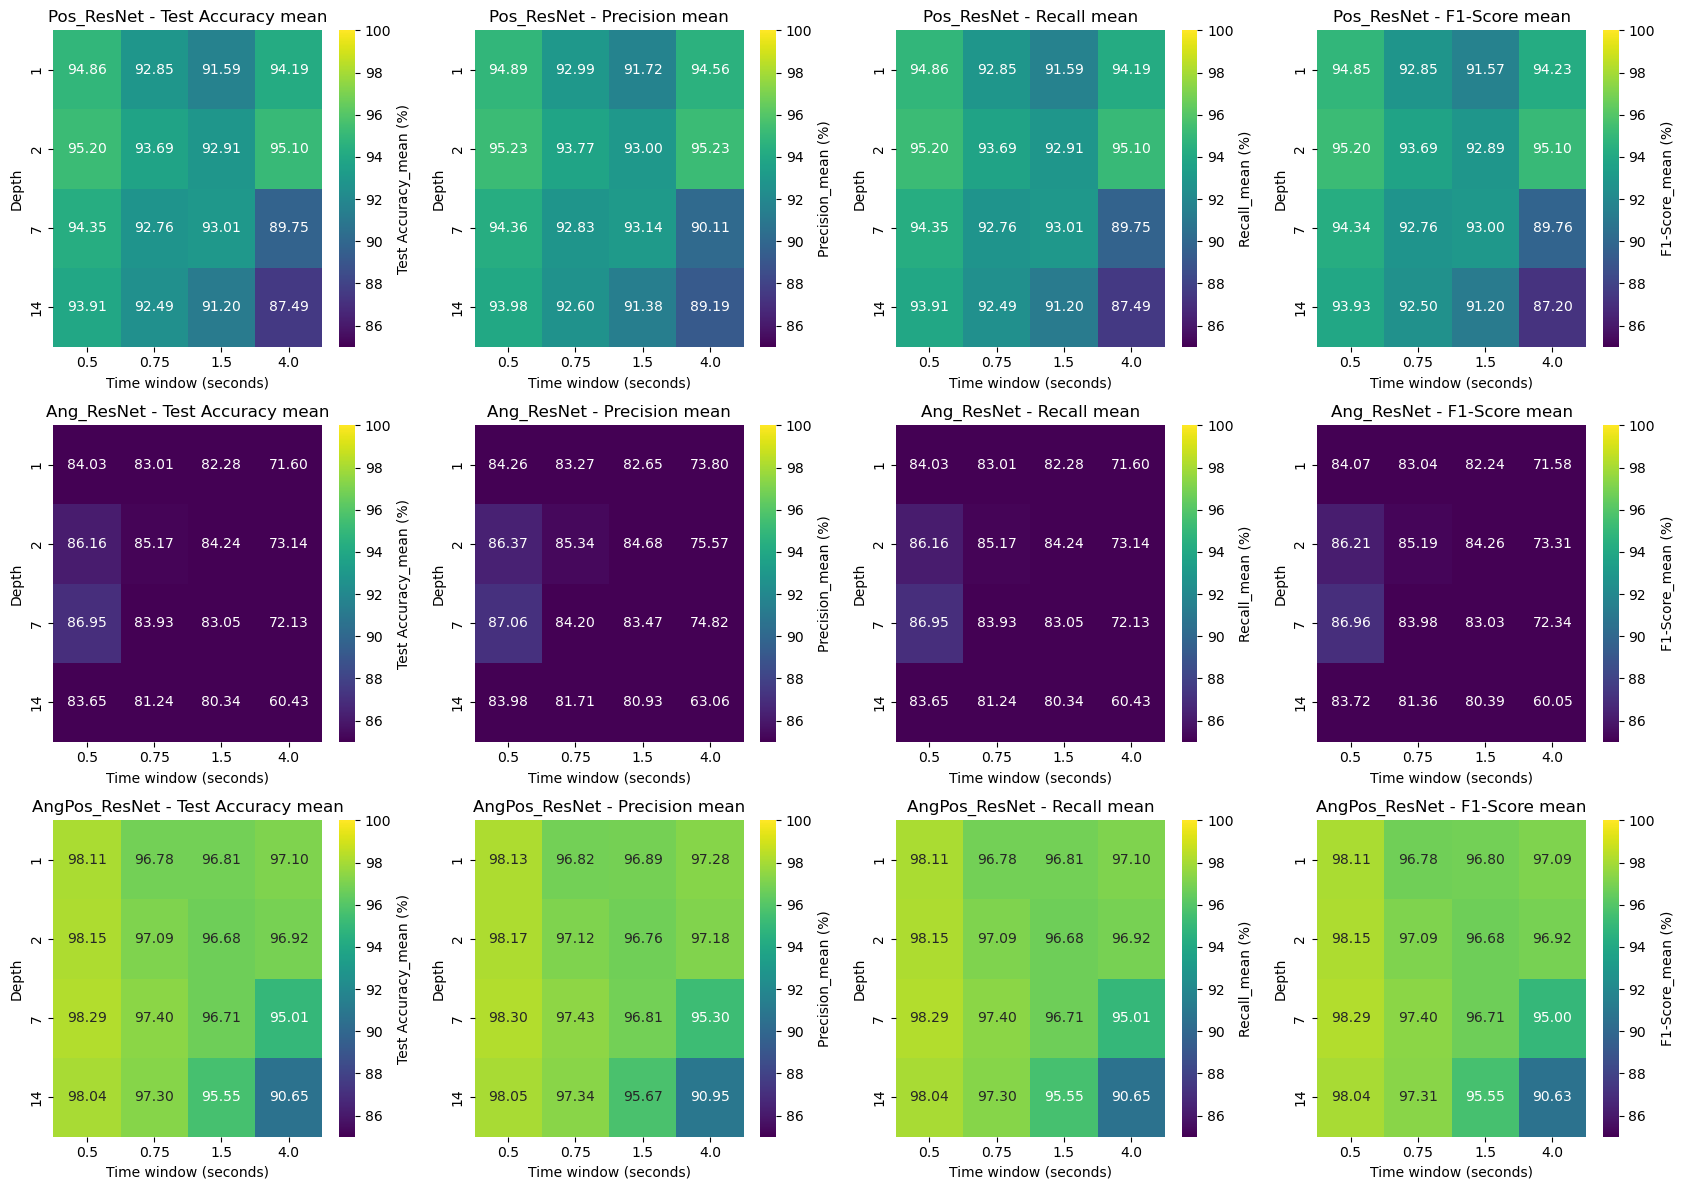

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to plot (excluding Loss_mean)
metrics = ["Test Accuracy_mean", "Precision_mean", "Recall_mean", "F1-Score_mean"]

# Data summaries to plot
datasets = {
    "Pos_ResNet": df_pos_summary,
    "Ang_ResNet": df_ang_summary,
    "AngPos_ResNet": df_angpos_summary,
}

# Set up the figure
plt.figure(figsize=(17, 12))

# Iterate through each metric and dataset
for row_idx, (model_name, dataset) in enumerate(datasets.items()):
    for col_idx, metric in enumerate(metrics):
        # Pivot the data to create a matrix for heatmap
        heatmap_data = dataset.pivot(index="Depth", columns="Time window", values=metric)
        
        # Define limits for the color bar and transformation
        vmin, vmax = 85, 100  # Constrain between 85% and 100%
        heatmap_data *= 100  # Convert to percentages
        fmt = ".2f"  # Two decimal places
        cmap = "viridis" 
        
        # Plot the heatmap
        plt.subplot(len(datasets), len(metrics), row_idx * len(metrics) + col_idx + 1)
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=fmt,
            cmap=cmap,
            cbar_kws={'label': f"{metric} (%)"},
            vmin=vmin,
            vmax=vmax,
        )
        plt.title(f"{model_name} - {metric.replace('_', ' ')}")
        plt.xlabel("Time window (seconds)")
        plt.ylabel("Depth")

# Adjust layout
plt.tight_layout()
plt.savefig("evalCV.png")
plt.show()